In [1]:
import torch as torch
import torchvision as tv
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as image
# import cv2 as cv
from PIL import Image
import numpy as np
from torchvision.datasets.vision import VisionDataset
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import os.path
from torch import nn
from torchvision.datasets.mnist import read_image_file, read_label_file
from torchvision.datasets.utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity
from pdb import set_trace

In [2]:
class MNISTsuperimposed(VisionDataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/processed/training.pt``
            and  ``MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    mirrors = [
        'http://yann.lecun.com/exdb/mnist/',
        'https://ossci-datasets.s3.amazonaws.com/mnist/',
    ]

    resources = [
        ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
        ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
        ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")
    ]

    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(
            self,
            root,
            train= True,
            transform = None,
            target_transform = None,
            download = False,
    ):
        super(MNISTsuperimposed, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        self.train = train  # training set or test set

        if self._check_legacy_exist():
            self.data, self.targets = self._load_legacy_data()

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        self.data, self.targets = self._load_data()
        
    def _check_legacy_exist(self):
        processed_folder_exists = os.path.exists(self.processed_folder)
        if not processed_folder_exists:
            return False

        return all(
            check_integrity(os.path.join(self.processed_folder, file)) for file in (self.training_file, self.test_file)
        )

    def _load_legacy_data(self):
        # This is for BC only. We no longer cache the data in a custom binary, but simply read from the raw data
        # directly.
        data_file = self.training_file if self.train else self.test_file
        return torch.load(os.path.join(self.processed_folder, data_file))

    def _load_data(self):
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        data = read_image_file(os.path.join(self.raw_folder, image_file))
        #Technically, we do not even need the labels for now
        # We just need the clean images of both types
        randata = data[torch.randperm(data.shape[0]),:,:]
        targets = (data, randata)
        
        # TODO: extract label data
        
        # Now do the ambiguation here
        data1 = data + randata
        targets = (data1, data, randata)
        return data1, targets

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], (self.targets[0][index], self.targets[1][index], self.targets[2][index]) # self.labels[]
        # doing this so that it is consistent with all other datasets
        # to return a PIL Imagedata[torch.randperm(data.shape[0]),:,:]
        img = Image.fromarray(img.numpy(), mode='L')
        target0 = Image.fromarray(target[0].numpy(), mode='L')
        target1 = Image.fromarray(target[1].numpy(), mode='L')
        target2 = Image.fromarray(target[2].numpy(), mode='L')

        # TODO: extract label data

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = (self.target_transform(target0), self.target_transform(target1), self.target_transform(target2))
            

        return img, target

    def __len__(self):
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
            for url, _ in self.resources
        )

    def download(self):
        """Download the MNIST data if it doesn't exist already."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)

        # download files
        for filename, md5 in self.resources:
            for mirror in self.mirrors:
                url = "{}{}".format(mirror, filename)
                try:
                    print("Downloading {}".format(url))
                    download_and_extract_archive(
                        url, download_root=self.raw_folder,
                        filename=filename,
                        md5=md5
                    )
                except URLError as error:
                    print(
                        "Failed to download (trying next):\n{}".format(error)
                    )
                    continue
                finally:
                    print()
                break
            else:
                raise RuntimeError("Error downloading {}".format(filename))

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")

In [3]:
class Downsample(object):
    def __init__(self, size=[1,196]):
        self.size=size

    def __call__(self, tensor):
        img = np.squeeze(tensor)
        m = torch.nn.AvgPool2d(2, stride=2)
        return m(img.unsqueeze(0))

    def __repr__(self):
        return self.__class__.__name__+'({})'.format(self.size)

In [4]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     Downsample()
     ])
target_transform= transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor()
     ])
mnist_superimposed = MNISTsuperimposed("./MNIST data/train", train = True, download = True, transform = transform, target_transform=target_transform)

In [5]:
from torch.utils.data import DataLoader
trainset = DataLoader(mnist_superimposed, batch_size=64, shuffle = False)

In [6]:
def show_images(dataset, training = True):
    
    fig = plt.figure(figsize = (20, 14))
    rows = 3
    columns = 4
    j=0
    for i in range(1,columns*rows+1):
        if i >=1 and i< 5:
            fig.add_subplot(rows, columns, i)

            plt.imshow(dataset[i][0].squeeze(0))
        if i >=5 and i < 9:
            fig.add_subplot(rows, columns, i)
            plt.imshow(dataset[i-4][1][0].squeeze(0))
        if i >= 9 and i<13:
            fig.add_subplot(rows, columns, i)
            plt.imshow(dataset[i-8][1][1].squeeze(0))
        if i >= 13 and i<17:
            fig.add_subplot(rows, columns, i)
            plt.imshow(dataset[i-12][1][2].squeeze(0))

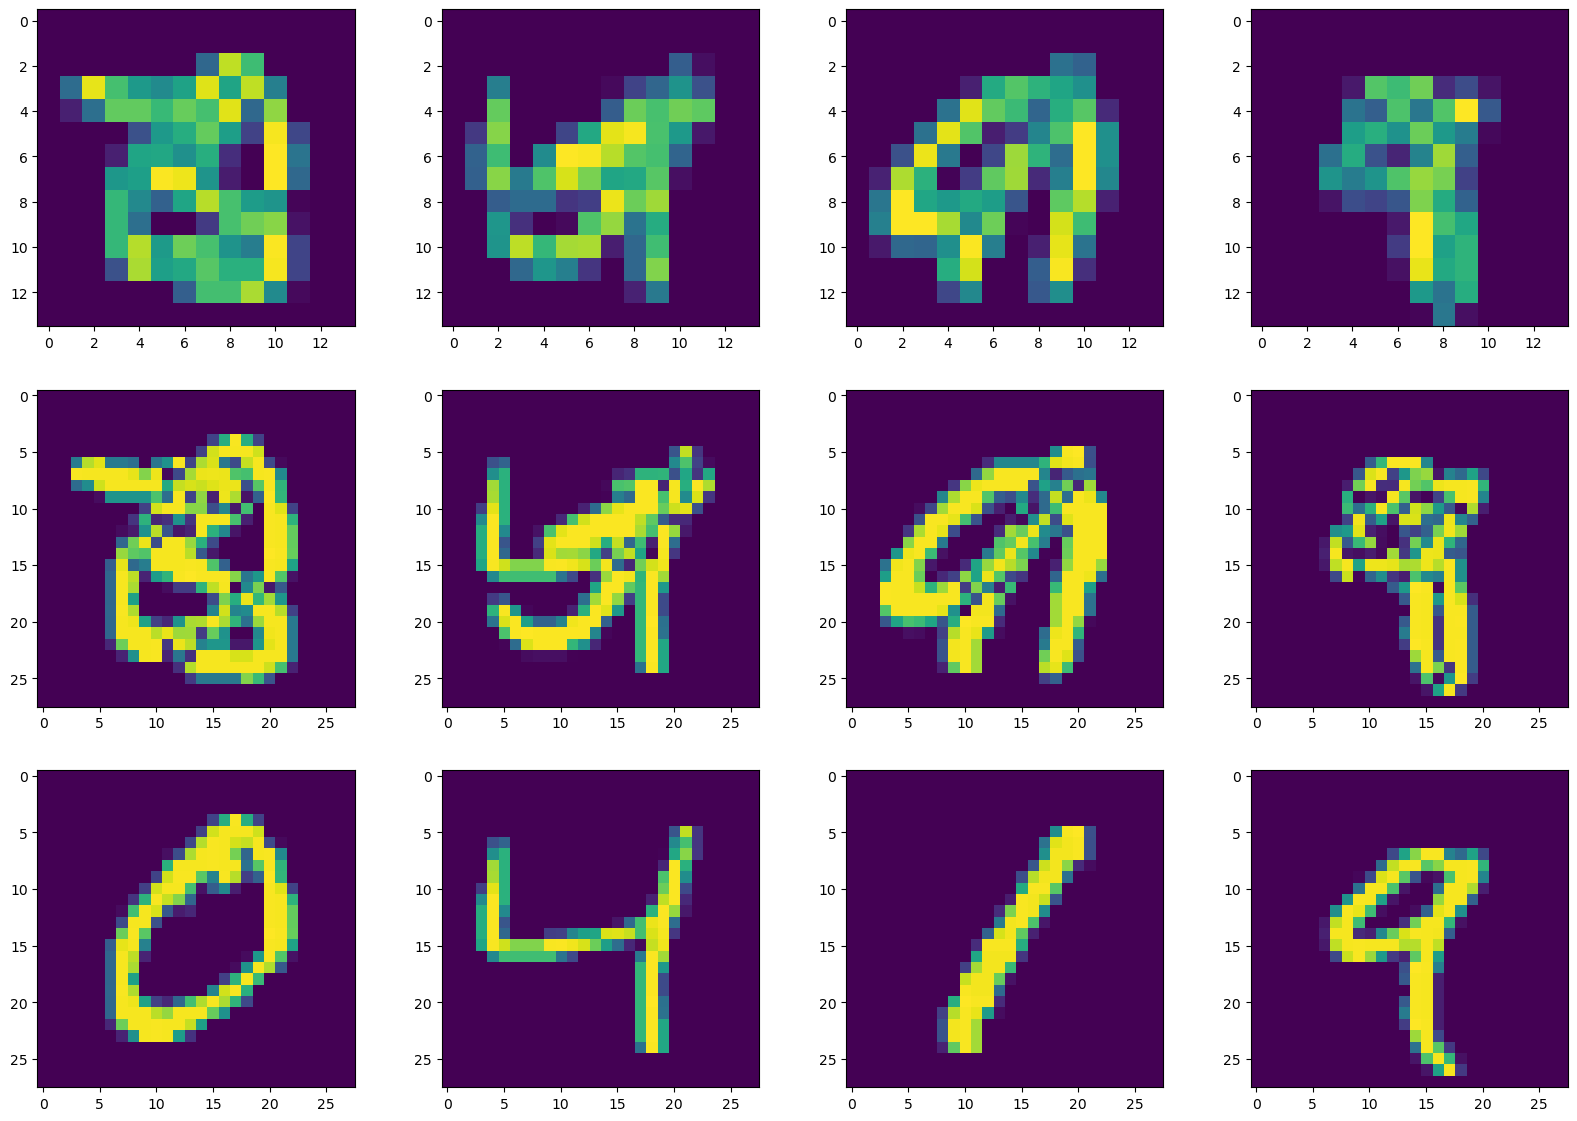

In [7]:
show_images(mnist_superimposed)

In [8]:
import torch
from torch import nn as nn
from torch.nn import Conv2d, ConvTranspose2d, Linear, Sequential, Flatten, ReLU

In [9]:
print(torch.cuda.is_available())

True


In [23]:
from pdb import set_trace
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()

        # Without downsample : input shape [batch, 1, 28, 28]
        # With downsample : input shape [batch, 1, 14, 14]
        self.Encoder = nn.Sequential(
            # batchnorm
            nn.Conv2d(1,32,kernel_size=2, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size =3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size =5, padding=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,kernel_size =3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size =5, padding=2, stride=2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,kernel_size =3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,64,kernel_size =3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,8,kernel_size =3, padding=1, stride=1),
            nn.ReLU())

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(8,64,kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64,128,kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128,64,kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,64,kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64,32,kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,32,kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,16,kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16,1,kernel_size=2,  stride=1),
            nn.LeakyReLU())

    
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

        self.disambiguate1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7, padding=3, stride=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=7, padding=3, stride=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=7, padding=3, stride=3, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=7, padding=3, stride=3, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5, padding=2, stride=2, output_padding=1),
            nn.Sigmoid()
        )
        
        self.disambiguate2 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7, padding=3, stride=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=7, padding=3, stride=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=7, padding=3, stride=3, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=7, padding=3, stride=3, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5, padding=2, stride=2, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self,x, flag=True):
        outputs = []
        if flag:
            batch  = x[0].shape[0]
            output = self.Encoder[:5](x[0])
            output = self.Encoder[6](output + self.Encoder[5](output))
            output = self.Encoder[7](output)
            output = self.Encoder[9:](self.Encoder[8](output) + output)
            output = self.Decoder[:5](output)
            output = self.Decoder[6](output + self.Decoder[5](output))
            output = self.Decoder[7](output)
            output = self.Decoder[9:](self.Decoder[8](output) + output)
            
            output = self.upsample[:](output)
            output = torch.flatten(output, 2)
            outputs.append(output)

            output = self.disambiguate1[:](x[1])
            I1 = output
            output = torch.flatten(output, 2)
            outputs.append(output.reshape(((batch, 1,784))))
            
            output = self.disambiguate2[:](x[1])
            output = torch.flatten(output, 2)
            outputs.append(output.reshape(((batch, 1,784))))
            
            
        else:
            
            
            batch  = x.shape[0]
            output = self.Encoder[:5](x)
            output = self.Encoder[6](output + self.Encoder[5](output))
            output = self.Encoder[7](output)
            output = self.Encoder[9:](self.Encoder[8](output) + output)
            output = self.Decoder[:5](output)
            output = self.Decoder[6](output + self.Decoder[5](output))
            output = self.Decoder[7](output)
            output = self.Decoder[9:](self.Decoder[8](output) + output)
            output = self.upsample[:](output)
            upsampled = output
            output = torch.flatten(output, 2)
            outputs.append(output)
            output = self.disambiguate1[:](upsampled)
            I1 = output
            output = torch.flatten(output, 2)
            outputs.append(output.reshape(((batch, 1,784))))
            
            output = self.disambiguate2[:](upsampled)
            output = torch.flatten(output, 2)
            outputs.append(output.reshape(((batch, 1,784))))
            
            
        return outputs

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
AEnet = AE().to(device)
optimizer = torch.optim.Adam(AEnet.parameters(), lr=1e-3)
# criterion2 = nn.BCEWithLogitsLoss()
# criterion2 = nn.MSELoss()
criterion2 = nn.HuberLoss()
print(device)
print(sum([parameter.numel() for parameter in AEnet.parameters()]))

cuda
2846224


In [25]:
epochs = 100
train_loss = []
flag = True
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainset):
        optimizer.zero_grad()
        # set_trace()
        outputs = AEnet((data[0].to(device) , data[1][0].to(device)), flag=True)
        loss = criterion2(outputs[0].squeeze(1),torch.flatten(data[1][0],1).to(device)) + \
        criterion2(outputs[1].squeeze(1),torch.flatten(data[1][1],1).to(device))+ \
        criterion2(outputs[2].squeeze(1),torch.flatten(data[1][2],1).to(device))
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss : %.6f' %
                  (epoch + 1, i + 1, loss.item()))
        
print('Finished Training')
flag = False

[1,   100] loss : 0.098176
[1,   200] loss : 0.085273
[1,   300] loss : 0.074551
[1,   400] loss : 0.072381
[1,   500] loss : 0.072708
[1,   600] loss : 0.065068
[1,   700] loss : 0.065465
[1,   800] loss : 0.069735
[1,   900] loss : 0.065314
[2,   100] loss : 0.059759
[2,   200] loss : 0.063992
[2,   300] loss : 0.059297
[2,   400] loss : 0.059855
[2,   500] loss : 0.061794
[2,   600] loss : 0.055175
[2,   700] loss : 0.056923
[2,   800] loss : 0.061018
[2,   900] loss : 0.057915
[3,   100] loss : 0.053489
[3,   200] loss : 0.057912
[3,   300] loss : 0.054337
[3,   400] loss : 0.054913
[3,   500] loss : 0.057086
[3,   600] loss : 0.051330
[3,   700] loss : 0.052729
[3,   800] loss : 0.057167
[3,   900] loss : 0.054148
[4,   100] loss : 0.050168
[4,   200] loss : 0.054425
[4,   300] loss : 0.051412
[4,   400] loss : 0.051980
[4,   500] loss : 0.054048
[4,   600] loss : 0.048827
[4,   700] loss : 0.049763
[4,   800] loss : 0.054234
[4,   900] loss : 0.051836
[5,   100] loss : 0.048039
[

In [26]:
#Print only the output images
def show_output_images(outputs, training = True):
    
    fig = plt.figure(figsize = (20, 14))
    rows = 3
    columns = 4
    j=0
    for i in range(1,columns*rows+1):
        if i >=1 and i< 5:
            fig.add_subplot(rows, columns, i)

            plt.imshow(outputs[0][i].cpu().detach().numpy().reshape(28,28), cmap='gray')
        if i >=5 and i < 9:
            fig.add_subplot(rows, columns, i)
            plt.imshow(outputs[1][i-4].cpu().detach().numpy().reshape(28,28), cmap='gray')
        if i >= 9 and i<13:
            fig.add_subplot(rows, columns, i)
            plt.imshow(outputs[2][i-8].cpu().detach().numpy().reshape(28,28), cmap='gray')

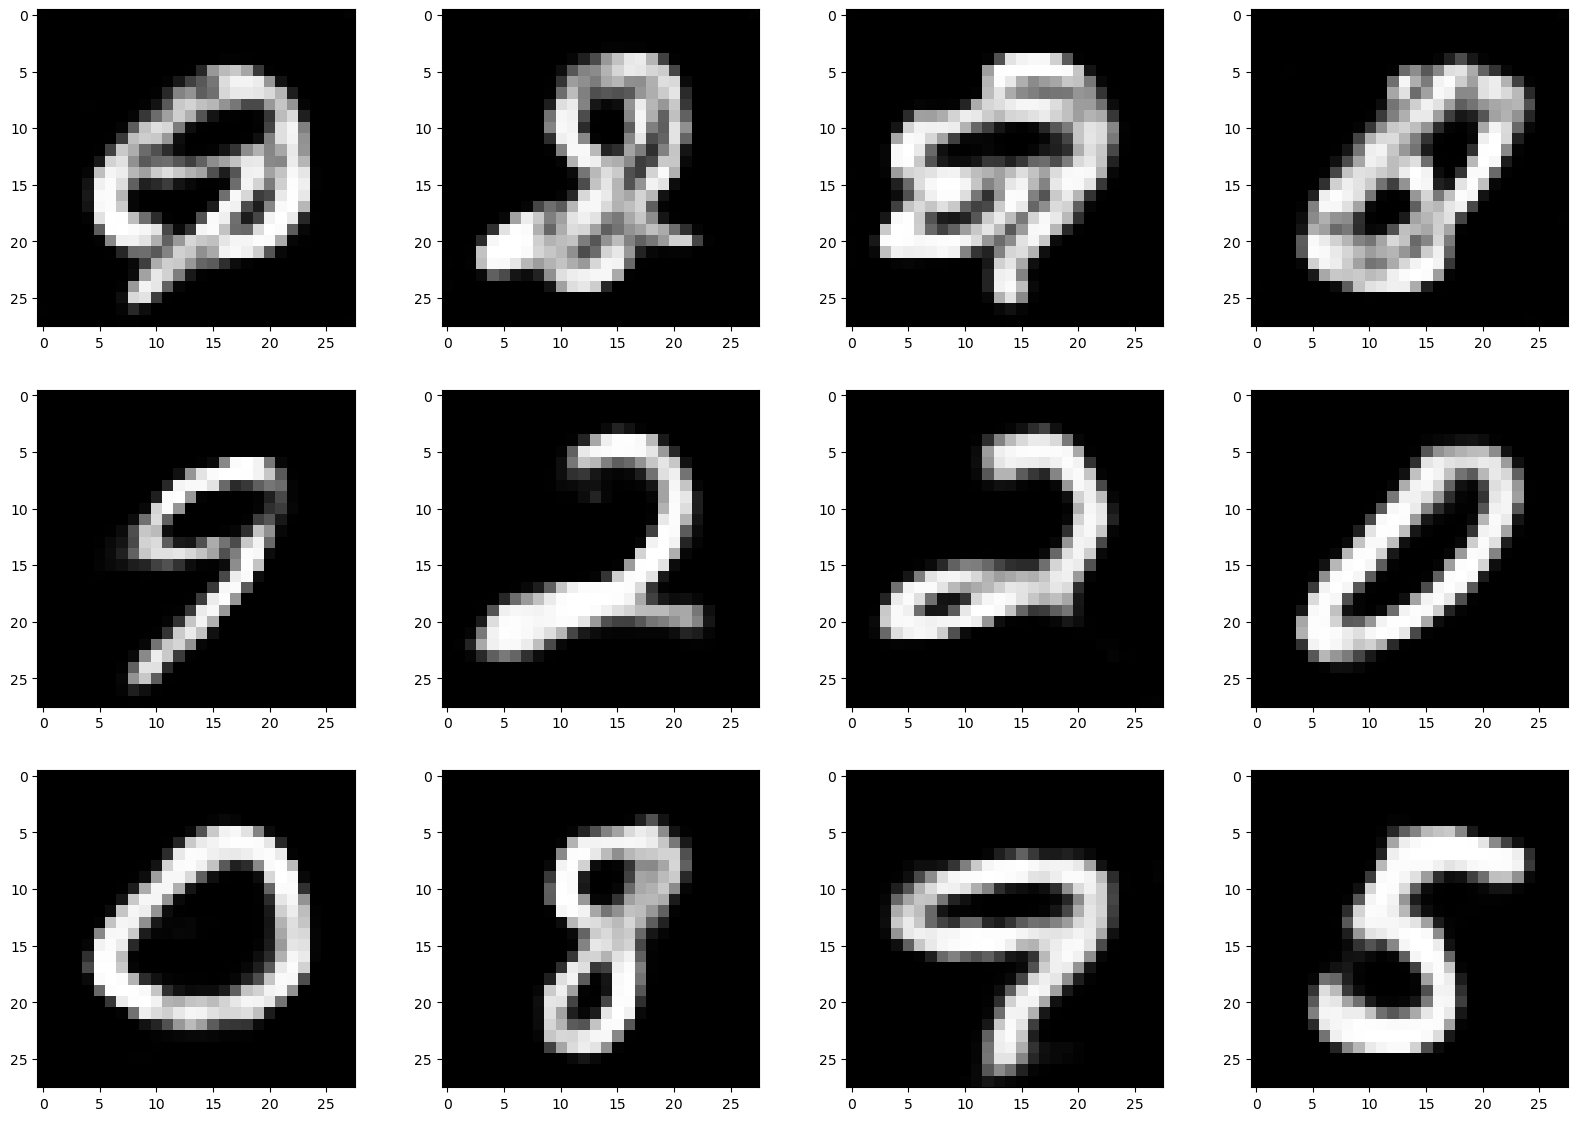

In [27]:
show_output_images(outputs)

In [28]:
#Print only the input images
def show_input_images(inputs, training = True):
    
    fig = plt.figure(figsize = (20, 14))
    rows = 3
    columns = 4
    j=0
    for i in range(1,columns*rows+1):
        if i >=1 and i< 5:
            fig.add_subplot(rows, columns, i)

            plt.imshow(inputs[0][i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        if i >=5 and i < 9:
            fig.add_subplot(rows, columns, i)
            plt.imshow(inputs[1][0][i-4].cpu().detach().numpy().reshape(28,28), cmap='gray')
        if i >= 9 and i<13:
            fig.add_subplot(rows, columns, i)
            plt.imshow(inputs[1][1][i-8].cpu().detach().numpy().reshape(28,28), cmap='gray')

In [16]:
# show_input_images(inputs=data)

In [29]:
import pdb
def test(AEnet, dataset, batch_size):

    testing_loss = []
    for i, data in enumerate(dataset):
        optimizer.zero_grad()
        outputs = AEnet(data[0].to(device), False)
        output_1 = outputs[1]
        output_2 = outputs[2]
        loss = criterion2(output_1.float().to(device), data[1][0].view_as(output_1).to(device)) + criterion2(output_2.float().to(device), data[1][1].view_as(output_2).to(device))
        testing_loss.append(loss.item()/batch_size)
        if i % 50 == 49:
            print('[%5d] average loss per image: %.6f' %
                (i + 1, loss.item()/batch_size))
                
    print("The lowest was: ", min(testing_loss))
    print('Finished Testing')
    return outputs, data

In [30]:
batch_size = 128
testing_superimposed = MNISTsuperimposed("./MNIST data/test", train = False, download = True, transform = transform, target_transform=target_transform)
testset = DataLoader(testing_superimposed, batch_size=batch_size, shuffle = False)
outputs, data = test(AEnet, testset, batch_size)

[   50] average loss per image: 0.000535
The lowest was:  0.00043656863272190094
Finished Testing


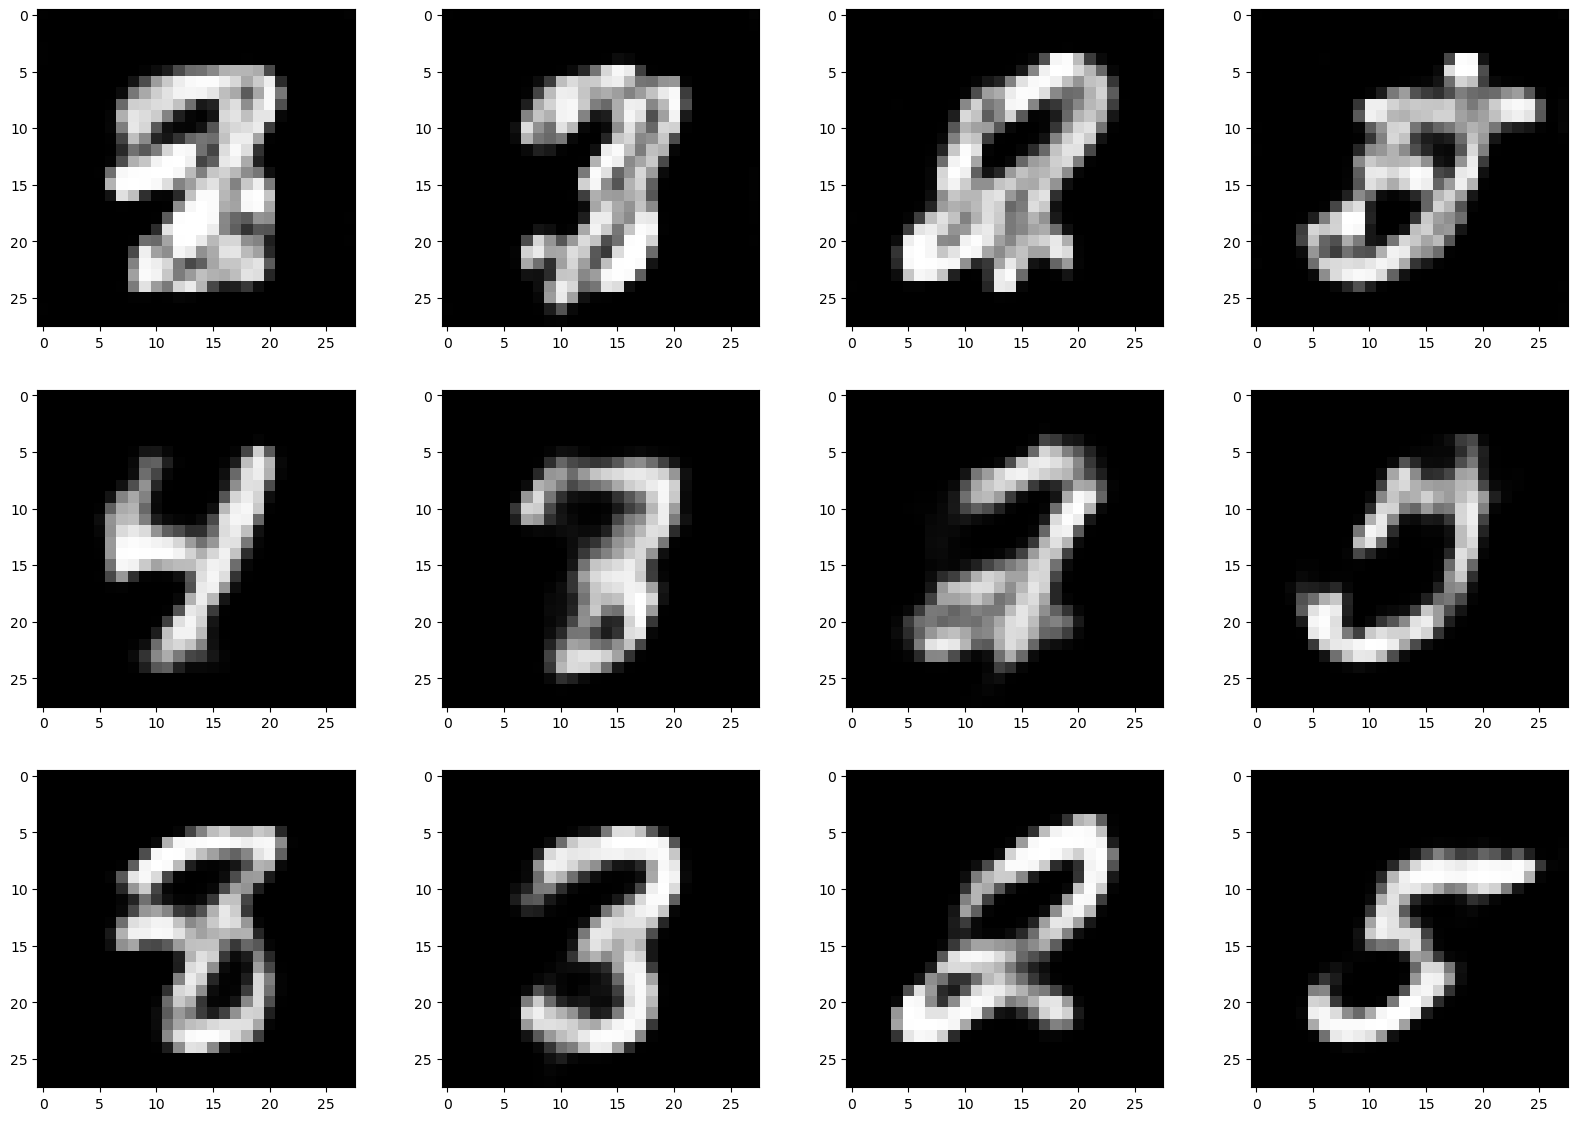

In [31]:
show_output_images(outputs)

In [32]:
def show_test_output(inputs, outputs):
    
    fig = plt.figure(figsize = (20, 14))
    rows = 7
    columns = 4
    j=0
    for i in range(1,columns*rows+1):
        if i >=1 and i< 5:
            fig.add_subplot(rows, columns, i)
            plt.imshow(inputs[0][i].cpu().detach().numpy().reshape(14,14), cmap='gray')
        if i >=5 and i < 9:
            fig.add_subplot(rows, columns, i)
            plt.imshow(outputs[0][i-4].cpu().detach().numpy().reshape(28,28), cmap='gray')
        if i >= 9 and i<13:
            fig.add_subplot(rows, columns, i)
            plt.imshow(outputs[1][i-8].cpu().detach().numpy().reshape(28,28), cmap='gray')
        if i >= 13 and i<17:
            fig.add_subplot(rows, columns, i)
            plt.imshow(outputs[2][i-12].cpu().detach().numpy().reshape(28,28), cmap='gray')
        if i >= 17 and i<21:
            fig.add_subplot(rows, columns, i)
            plt.imshow(inputs[1][0][i-16].cpu().detach().numpy().reshape(28,28), cmap='gray')
        if i >= 21 and i<25:
            fig.add_subplot(rows, columns, i)
            plt.imshow(inputs[1][1][i-20].cpu().detach().numpy().reshape(28,28), cmap='gray')
        if i >= 25 and i<29:
            fig.add_subplot(rows, columns, i)
            plt.imshow(inputs[1][2][i-24].cpu().detach().numpy().reshape(28,28), cmap='gray')

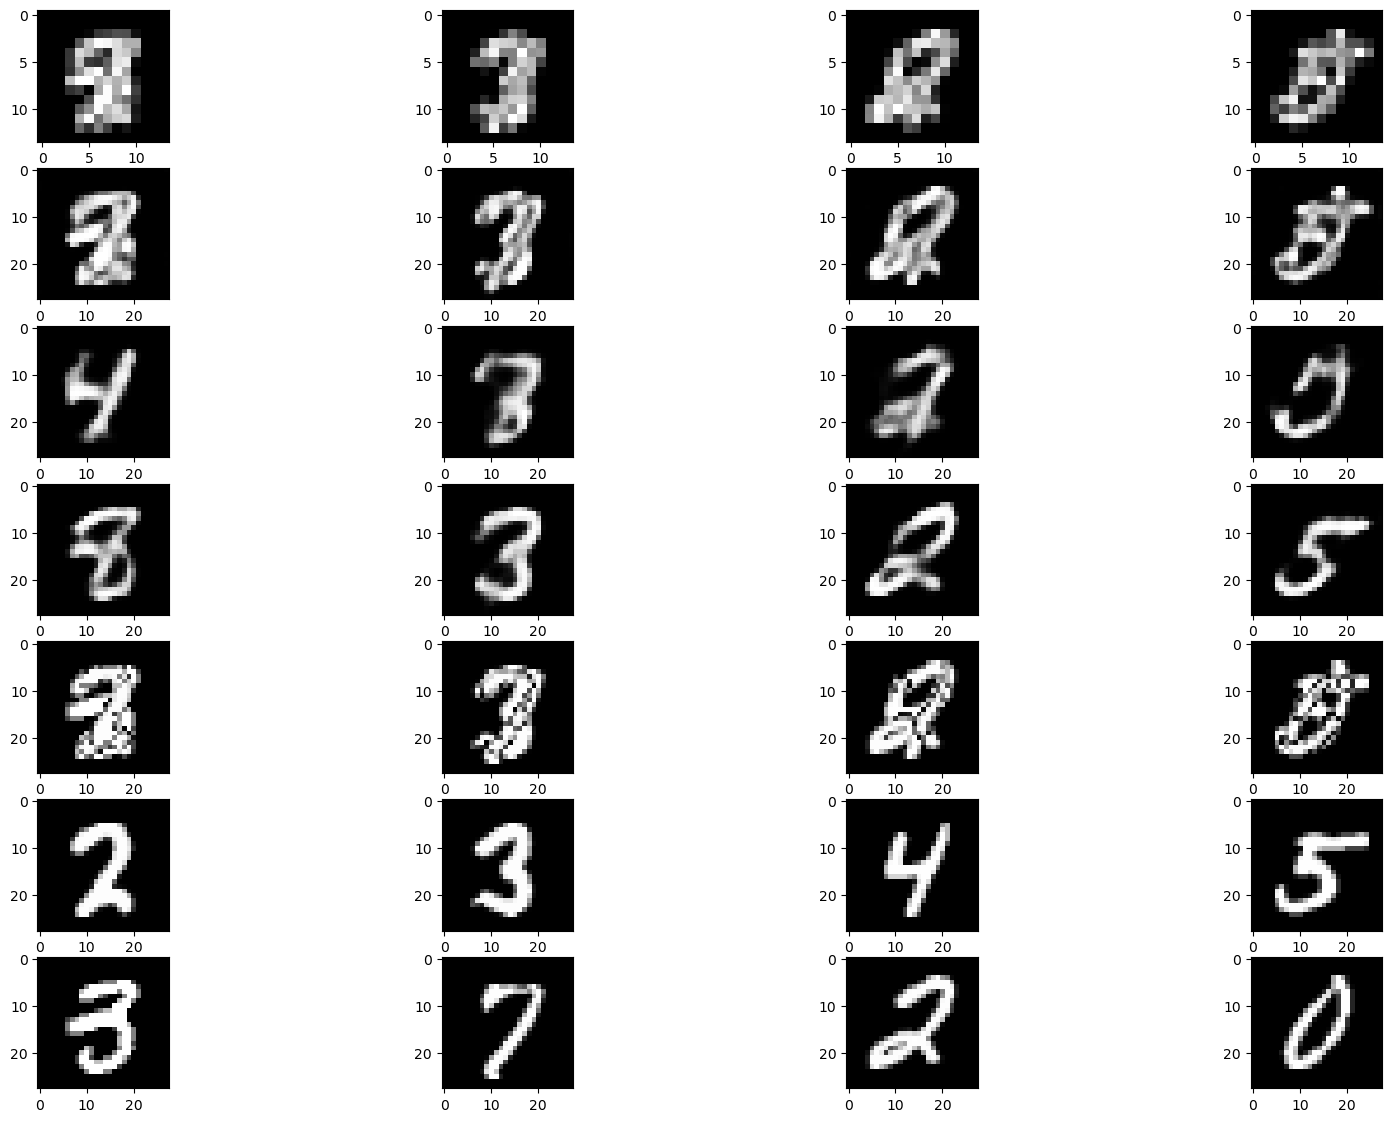

In [33]:
show_test_output(data, outputs)